In [1]:
import os
import glob
import numpy as np
import torch
from torch.utils.data import Dataset
import tifffile
import json
from scipy.ndimage import zoom
import cv2
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from model import ConvAutoEncoder,UNetAutoEncoder

In [2]:

class ClassificationDataset(Dataset):
    """Dataset for Sentinel-2 multi-spectral inpainting"""
    
    def __init__(self, root_dir, mask_type='random', augment=False, target_size=None):
        """
        Args:
            root_dir: Path to s2a folder (e.g., 'D:/s2a')
            mask_type: 'random', 'center', or 'irregular'
            augment: Apply random flips/rotations
            target_size: (H, W) to resize all images, or None to use 10m resolution
        """
        self.root_dir = root_dir
        self.mask_type = mask_type
        self.augment = augment
        self.target_size = target_size
        
        # Band names in order (12 bands total)
        self.bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
        
        # Band resolutions (in meters)
        self.band_resolutions = {
            'B1': 60, 'B2': 10, 'B3': 10, 'B4': 10,
            'B5': 20, 'B6': 20, 'B7': 20, 'B8': 10,
            'B8A': 20, 'B9': 60, 'B11': 20, 'B12': 20
        }
        
        # Find all timestamped folders
        self.samples = []
        for region_folder in tqdm(glob.glob(os.path.join(root_dir, '*'))):
            if os.path.isdir(region_folder):
                if(region_folder[-3:] == "RPH"): label = "RPH"
                elif(region_folder[-5:] == "Blast"): label = "Blast"
                elif(region_folder[-4:] == "Rust"): label = "Rust"
                elif(region_folder[-5:] == "Aphid"): label = "Aphid"
                else: continue

                for timestamp_folder in glob.glob(os.path.join(region_folder, '*')):
                    if os.path.isdir(timestamp_folder):
                        # Check if all bands exist
                        band_paths = {band: os.path.join(timestamp_folder, f'{band}.tif') 
                                     for band in self.bands}
                        if all(os.path.exists(p) for p in band_paths.values()):
                            self.samples.append((band_paths,label))
        
        print(f"Found {len(self.samples)} samples with all 12 bands")
    
    def __len__(self):
        return len(self.samples)
    
    def resize_band(self, band_data, target_shape):
        """Resize a band to target shape using bilinear interpolation"""
        if band_data.shape == target_shape:
            return band_data
        
        # Use OpenCV for faster resizing
        resized = cv2.resize(
            band_data, 
            (target_shape[1], target_shape[0]),  # OpenCV uses (W, H)
            interpolation=cv2.INTER_LINEAR
        )
        return resized
    
    def load_multispectral_image(self, band_paths):
        """Load all 12 bands and stack them with consistent resolution"""
        bands_data = []
        shapes = []
        
        # First pass: load all bands and record shapes
        loaded_bands = {}
        for band in self.bands:
            img = tifffile.imread(band_paths[band])
            loaded_bands[band] = img
            shapes.append(img.shape)
        
        # Determine target shape
        if self.target_size is not None:
            target_shape = self.target_size
        else:
            # Use the shape of 10m bands (B2, B3, B4, B8) as reference
            # These are typically the largest
            reference_band = loaded_bands['B4']  # 10m band
            target_shape = reference_band.shape
        
        # Second pass: resize all bands to target shape
        for band in self.bands:
            img = loaded_bands[band]
            
            # Resize if needed
            if img.shape != target_shape:
                img = self.resize_band(img, target_shape)
            
            bands_data.append(img)
        
        # Stack along channel dimension: (12, H, W)
        multi_band = np.stack(bands_data, axis=0)
        return multi_band
    
    def normalize_sentinel2(self, img):
        """
        Normalize Sentinel-2 data to [0, 1]
        Sentinel-2 L1C has typical range 0-10000 (reflectance * 10000)
        """
        # Clip extreme values and normalize
        img = np.clip(img, 0, 10000)
        img = img.astype(np.float32) / 10000.0
        return img
    
    def create_random_mask(self, shape, num_masks=None):
        """Create random rectangular mask(s)"""
        C, H, W = shape
        mask = np.ones((C, H, W), dtype=np.float32)
        
        if num_masks is None:
            num_masks = np.random.randint(1, 4)
        
        for _ in range(num_masks):
            mask_h = np.random.randint(32, min(128, H // 2))
            mask_w = np.random.randint(32, min(128, W // 2))
            
            top = np.random.randint(0, H - mask_h)
            left = np.random.randint(0, W - mask_w)
            
            # Mask all channels
            mask[:, top:top+mask_h, left:left+mask_w] = 0
        
        return mask
    
    def create_center_mask(self, shape, mask_ratio=0.25):
        """Create centered square mask"""
        C, H, W = shape
        mask = np.ones((C, H, W), dtype=np.float32)
        
        mask_size = int(min(H, W) * mask_ratio)
        top = (H - mask_size) // 2
        left = (W - mask_size) // 2
        
        mask[:, top:top+mask_size, left:left+mask_size] = 0
        return mask
    
    def augment_data(self, img):
        """Random flips and rotations"""
        # Random horizontal flip
        if np.random.random() > 0.5:
            img = np.flip(img, axis=2).copy()
        
        # Random vertical flip
        if np.random.random() > 0.5:
            img = np.flip(img, axis=1).copy()
        
        # Random 90 degree rotations
        k = np.random.randint(0, 4)
        if k > 0:
            img = np.rot90(img, k, axes=(1, 2)).copy()
        
        return img
    
    def __getitem__(self, idx):
        # Load all 12 bands
        band_paths,label = self.samples[idx]
        img = self.load_multispectral_image(band_paths)
        
        # Normalize
        img = self.normalize_sentinel2(img)
        
        # Augmentation
        if self.augment:
            img = self.augment_data(img)

        if(label == "RPH"): label = 0
        elif(label == "Blast"): label = 1
        elif(label == "Rust"): label = 2
        elif(label == "Aphid"): label = 3
      
        return {
            'original': img,
            'label' : label
        }


In [3]:
import numpy as np
from torch.utils.data import Subset, DataLoader


def create_balanced_split(dataset, val_samples_per_class=20, max_train_per_class=100):
    """
    Create balanced train/val split with fixed number of samples per class
    
    Args:
        dataset: Your ClassificationDataset
        val_samples_per_class: Number of samples per class for validation
        max_train_per_class: Maximum number of samples per class for training
    
    Returns:
        train_indices, val_indices
    """
    # Get all labels
    all_labels = []
    for idx in range(len(dataset)):
        sample = dataset[idx]
        all_labels.append(sample['label'])
    
    all_labels = np.array(all_labels)
    
    # Get indices for each class
    class_indices = {
        0: np.where(all_labels == 0)[0],  # RPH
        1: np.where(all_labels == 1)[0],  # Blast
        2: np.where(all_labels == 2)[0],  # Rust
        3: np.where(all_labels == 3)[0],  # Aphid
    }
    
    # Print original class distribution
    print("Original class distribution:")
    class_names = ['RPH', 'Blast', 'Rust', 'Aphid']
    for cls_id, indices in class_indices.items():
        print(f"  {class_names[cls_id]}: {len(indices)} samples")
    
    train_indices = []
    val_indices = []
    
    print(f"\nSplitting with {val_samples_per_class} val and max {max_train_per_class} train per class:")
    
    # For each class, split into train/val
    for cls_id, indices in class_indices.items():
        # Shuffle indices for this class
        np.random.seed(42)  # For reproducibility
        shuffled = indices.copy()
        np.random.shuffle(shuffled)
        
        # Take first val_samples_per_class for validation
        val_idx = shuffled[:val_samples_per_class]
        
        # Take next max_train_per_class for training (limit to max)
        remaining = shuffled[val_samples_per_class:]
        train_idx = remaining[:max_train_per_class]
        
        # Calculate how many were left out
        left_out = len(remaining) - len(train_idx)
        
        val_indices.extend(val_idx)
        train_indices.extend(train_idx)
        
        print(f"  {class_names[cls_id]}: {len(train_idx)} train, {len(val_idx)} val, {left_out} left out")
    
    # Shuffle the final indices
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)
    
    print(f"\nFinal counts:")
    print(f"  Training: {len(train_indices)} samples")
    print(f"  Validation: {len(val_indices)} samples")
    print(f"  Total used: {len(train_indices) + len(val_indices)} / {len(dataset)}")
    
    return train_indices, val_indices


# Create dataset
cdata = ClassificationDataset(
    root_dir="C:\\Users\\ayush\\OneDrive\\Desktop\\Agriculture\\ICPR02\\kaggle",
    mask_type='random',
    augment=True,
    target_size=(256, 256)
)

# Create balanced split with limits
train_indices, val_indices = create_balanced_split(
    cdata, 
    val_samples_per_class=20,
    max_train_per_class=100  # Limit to 100 training samples per class
)

# Create Subset datasets
train_dataset = Subset(cdata, train_indices)
val_dataset = Subset(cdata, val_indices)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
)

print(f"\nDataLoaders created successfully!")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")


100%|██████████| 5/5 [00:01<00:00,  4.86it/s]


Found 900 samples with all 12 bands
Original class distribution:
  RPH: 495 samples
  Blast: 75 samples
  Rust: 40 samples
  Aphid: 290 samples

Splitting with 20 val and max 100 train per class:
  RPH: 100 train, 20 val, 375 left out
  Blast: 55 train, 20 val, 0 left out
  Rust: 20 train, 20 val, 0 left out
  Aphid: 100 train, 20 val, 170 left out

Final counts:
  Training: 275 samples
  Validation: 80 samples
  Total used: 355 / 900

DataLoaders created successfully!
Train batches: 18
Val batches: 5


In [40]:
class ClassificationModel(nn.Module):
    def __init__(self, *args, **kwargs ,):
        super().__init__(*args, **kwargs)
       

        
        self.pool2d = nn.MaxPool2d(kernel_size=2) 
        self.conv1 = nn.Conv2d(12,32,kernel_size=3,stride=1)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,stride=1)
        self.conv3 = nn.Conv2d(64,32,kernel_size=3,stride=1)
   
                       
        self.flatten = nn.Flatten() # 20 * 20 * 32
        self.fc1 = nn.Linear(30 * 30 * 32 ,30 * 32)
        self.fc2 = nn.Linear(30 * 32,16 * 16)
        self.fc3 = nn.Linear(16 * 16 ,4)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        

    def forward(self,x):
        x = self.conv1(x)
        x = self.pool2d(x)
        x = self.conv2(x)
        x = self.pool2d(x)
        x = self.conv3(x)
        x = self.pool2d(x)

        x = self.flatten(x)
     
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)

        return x
    

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

def train_classification_model(
    model,
    train_loader,
    val_loader,
    num_epochs=50,
    learning_rate=1e-3,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_dir='sanity_classification_checkpoints'
):
    os.makedirs(save_dir, exist_ok=True)
    
    # Move model to device
    model = model.to(device)
    
    # Freeze encoder (optional - remove these lines if you want to fine-tune)

    # Loss and optimizer
    class_weights = torch.tensor([1.0, 2.0, 2.0, 1.0]).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
    
    # Tracking
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0
    
    print(f"Training on {device}")
    print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    
    for epoch in range(num_epochs):
        # ================== TRAINING ==================
        model.train()
        # Keep encoder in eval mode if frozen
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch in pbar:
            images = batch['original'].to(device)
            labels = batch['label'].to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100. * correct / total:.2f}%'
            })
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # ================== VALIDATION ==================
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for batch in pbar:
                images = batch['original'].to(device)
                labels = batch['label'].to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{100. * val_correct / val_total:.2f}%'
                })
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Print epoch summary
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%')
        
        # Learning rate scheduling
        scheduler.step(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc,
            }, os.path.join(save_dir, 'best_classifier.pth'))
            print(f'  ✓ Saved best model with val_acc = {val_acc:.2f}%')
        
        # Save checkpoint every 10 epochs
        if (epoch + 1) % 5 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth'))
        
        print('-' * 60)
    
    # Plot training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy plot
    ax2.plot(train_accs, label='Train Acc', marker='o')
    ax2.plot(val_accs, label='Val Acc', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_curves.png'), dpi=150)
    plt.show()
    
    print(f'\n🎉 Training complete!')
    print(f'Best validation accuracy: {best_val_acc:.2f}%')
    
    return model, {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }

Training on cuda
Total trainable parameters: 27,936,452


Epoch 1/25 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]c:\Users\ayush\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\module.py:1775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 1/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.98it/s, loss=1.4093, acc=26.25%]



Epoch 1/25:
  Train Loss: 1.3789 | Train Acc: 33.09%
  Val Loss:   1.4072 | Val Acc:   26.25%
  ✓ Saved best model with val_acc = 26.25%
------------------------------------------------------------


Epoch 2/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  4.07it/s, loss=1.4286, acc=33.75%]



Epoch 2/25:
  Train Loss: 1.3566 | Train Acc: 34.55%
  Val Loss:   1.4278 | Val Acc:   33.75%
  ✓ Saved best model with val_acc = 33.75%
------------------------------------------------------------


Epoch 3/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  4.00it/s, loss=1.3998, acc=38.75%]



Epoch 3/25:
  Train Loss: 1.3494 | Train Acc: 35.64%
  Val Loss:   1.4042 | Val Acc:   38.75%
  ✓ Saved best model with val_acc = 38.75%
------------------------------------------------------------


Epoch 4/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.92it/s, loss=1.3733, acc=36.25%]



Epoch 4/25:
  Train Loss: 1.3443 | Train Acc: 25.09%
  Val Loss:   1.4006 | Val Acc:   36.25%
------------------------------------------------------------


Epoch 5/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  4.02it/s, loss=1.4029, acc=36.25%]



Epoch 5/25:
  Train Loss: 1.3249 | Train Acc: 36.36%
  Val Loss:   1.3888 | Val Acc:   36.25%
------------------------------------------------------------


Epoch 6/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.74it/s, loss=1.3573, acc=38.75%]



Epoch 6/25:
  Train Loss: 1.3092 | Train Acc: 45.09%
  Val Loss:   1.3649 | Val Acc:   38.75%
------------------------------------------------------------


Epoch 7/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  4.12it/s, loss=1.4212, acc=36.25%]



Epoch 7/25:
  Train Loss: 1.2916 | Train Acc: 49.09%
  Val Loss:   1.3752 | Val Acc:   36.25%
------------------------------------------------------------


Epoch 8/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  4.01it/s, loss=1.3166, acc=43.75%]



Epoch 8/25:
  Train Loss: 1.2787 | Train Acc: 46.55%
  Val Loss:   1.3332 | Val Acc:   43.75%
  ✓ Saved best model with val_acc = 43.75%
------------------------------------------------------------


Epoch 9/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.29it/s, loss=1.2893, acc=46.25%]



Epoch 9/25:
  Train Loss: 1.2463 | Train Acc: 50.91%
  Val Loss:   1.3124 | Val Acc:   46.25%
  ✓ Saved best model with val_acc = 46.25%
------------------------------------------------------------


Epoch 10/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.91it/s, loss=1.2730, acc=40.00%]



Epoch 10/25:
  Train Loss: 1.1968 | Train Acc: 51.27%
  Val Loss:   1.3780 | Val Acc:   40.00%
------------------------------------------------------------


Epoch 11/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  4.04it/s, loss=1.2799, acc=41.25%]



Epoch 11/25:
  Train Loss: 1.2157 | Train Acc: 49.82%
  Val Loss:   1.3517 | Val Acc:   41.25%
------------------------------------------------------------


Epoch 12/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  4.14it/s, loss=1.3256, acc=45.00%]



Epoch 12/25:
  Train Loss: 1.2014 | Train Acc: 53.09%
  Val Loss:   1.3003 | Val Acc:   45.00%
------------------------------------------------------------


Epoch 13/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.89it/s, loss=1.3531, acc=40.00%]



Epoch 13/25:
  Train Loss: 1.2144 | Train Acc: 50.18%
  Val Loss:   1.3286 | Val Acc:   40.00%
------------------------------------------------------------


Epoch 14/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.95it/s, loss=1.2810, acc=43.75%]



Epoch 14/25:
  Train Loss: 1.2075 | Train Acc: 54.91%
  Val Loss:   1.3308 | Val Acc:   43.75%
------------------------------------------------------------


Epoch 15/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.69it/s, loss=1.2997, acc=36.25%]



Epoch 15/25:
  Train Loss: 1.2211 | Train Acc: 55.27%
  Val Loss:   1.4166 | Val Acc:   36.25%
------------------------------------------------------------


Epoch 16/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.95it/s, loss=1.3371, acc=38.75%]



Epoch 16/25:
  Train Loss: 1.2240 | Train Acc: 54.91%
  Val Loss:   1.3077 | Val Acc:   38.75%
------------------------------------------------------------


Epoch 17/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.65it/s, loss=1.3226, acc=32.50%]



Epoch 17/25:
  Train Loss: 1.1759 | Train Acc: 54.18%
  Val Loss:   1.4374 | Val Acc:   32.50%
------------------------------------------------------------


Epoch 18/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.96it/s, loss=1.3333, acc=41.25%]



Epoch 18/25:
  Train Loss: 1.1701 | Train Acc: 54.55%
  Val Loss:   1.3208 | Val Acc:   41.25%
------------------------------------------------------------


Epoch 19/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.95it/s, loss=1.3225, acc=37.50%]



Epoch 19/25:
  Train Loss: 1.1644 | Train Acc: 57.45%
  Val Loss:   1.3913 | Val Acc:   37.50%
------------------------------------------------------------


Epoch 20/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.93it/s, loss=1.2877, acc=46.25%]



Epoch 20/25:
  Train Loss: 1.1790 | Train Acc: 56.73%
  Val Loss:   1.2840 | Val Acc:   46.25%
------------------------------------------------------------


Epoch 21/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.95it/s, loss=1.2856, acc=47.50%]



Epoch 21/25:
  Train Loss: 1.1974 | Train Acc: 53.45%
  Val Loss:   1.2869 | Val Acc:   47.50%
  ✓ Saved best model with val_acc = 47.50%
------------------------------------------------------------


Epoch 22/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  4.04it/s, loss=1.3317, acc=38.75%]



Epoch 22/25:
  Train Loss: 1.1639 | Train Acc: 57.09%
  Val Loss:   1.3954 | Val Acc:   38.75%
------------------------------------------------------------


Epoch 23/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.73it/s, loss=1.2854, acc=45.00%]



Epoch 23/25:
  Train Loss: 1.1984 | Train Acc: 53.82%
  Val Loss:   1.2989 | Val Acc:   45.00%
------------------------------------------------------------


Epoch 24/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  4.13it/s, loss=1.3220, acc=43.75%]



Epoch 24/25:
  Train Loss: 1.1462 | Train Acc: 58.91%
  Val Loss:   1.3133 | Val Acc:   43.75%
------------------------------------------------------------


Epoch 25/25 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.99it/s, loss=1.3126, acc=37.50%]



Epoch 25/25:
  Train Loss: 1.1717 | Train Acc: 55.27%
  Val Loss:   1.3866 | Val Acc:   37.50%
------------------------------------------------------------


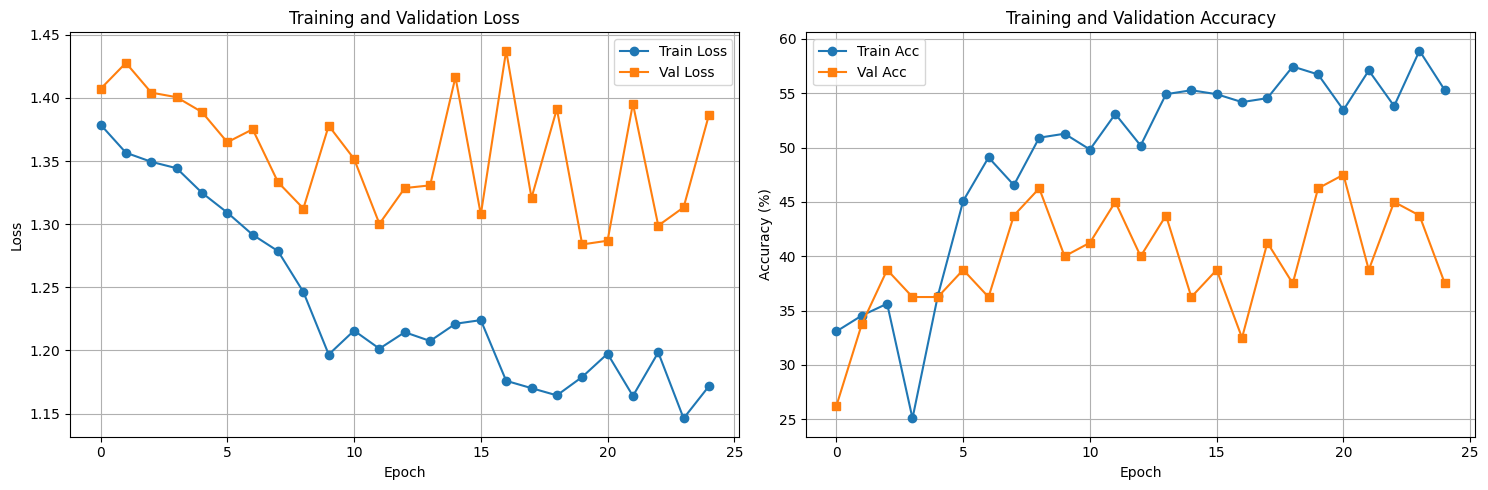


🎉 Training complete!
Best validation accuracy: 47.50%


In [49]:
model = ClassificationModel()
trained_model, history = train_classification_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=25,
    learning_rate=1e-4,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

In [50]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


def evaluate_model(model, dataloader, device='cuda', class_names=['RPH', 'Blast', 'Rust', 'Aphid'], save_path=None):
    """
    Evaluate model and display classification report and confusion matrix
    
    Args:
        model: PyTorch model to evaluate
        dataloader: DataLoader with test/validation data
        device: 'cuda' or 'cpu'
        class_names: List of class names for display
        save_path: Optional path to save confusion matrix image
    
    Returns:
        dict with predictions, labels, accuracy, and confusion matrix
    """
    model.eval()
    model.to(device)
    
    predictions = []
    ground_truth_labels = []
    
    print("Evaluating model...")
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            images = batch['original'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            predictions.extend(predicted.cpu().numpy())
            ground_truth_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    predictions = np.array(predictions)
    ground_truth_labels = np.array(ground_truth_labels)
    
    # Calculate overall accuracy
    accuracy = 100. * np.sum(predictions == ground_truth_labels) / len(ground_truth_labels)
    
    # Print classification report
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(ground_truth_labels, predictions, 
                                target_names=class_names, 
                                digits=4))
    
    # Create confusion matrix
    cm = confusion_matrix(ground_truth_labels, predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.title(f'Confusion Matrix\nOverall Accuracy: {accuracy:.2f}%', fontsize=14)
    
    # Add percentage annotations
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            total = cm[i].sum()
            if total > 0:
                percentage = cm[i, j] / total * 100
                plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                        ha='center', va='center', fontsize=9, color='gray')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n✓ Confusion matrix saved to: {save_path}")
    
    plt.show()
    
    # Print summary
    print("\n" + "="*60)
    print(f"Overall Accuracy: {accuracy:.2f}%")
    print(f"Total Samples: {len(ground_truth_labels)}")
    print("="*60 + "\n")
    
    return {
        'predictions': predictions,
        'labels': ground_truth_labels,
        'accuracy': accuracy,
        'confusion_matrix': cm
    }



FINAL EVALUATION ON BEST MODEL
Evaluating model...


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]
c:\Users\ayush\anaconda3\envs\torch\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ayush\anaconda3\envs\torch\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ayush\anaconda3\envs\torch\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m


CLASSIFICATION REPORT
              precision    recall  f1-score   support

         RPH     0.2857    0.1000    0.1481        20
       Blast     0.4722    0.8500    0.6071        20
        Rust     0.0000    0.0000    0.0000        20
       Aphid     0.5135    0.9500    0.6667        20

    accuracy                         0.4750        80
   macro avg     0.3179    0.4750    0.3555        80
weighted avg     0.3179    0.4750    0.3555        80


✓ Confusion matrix saved to: classification_checkpoints/final_confusion_matrix.png


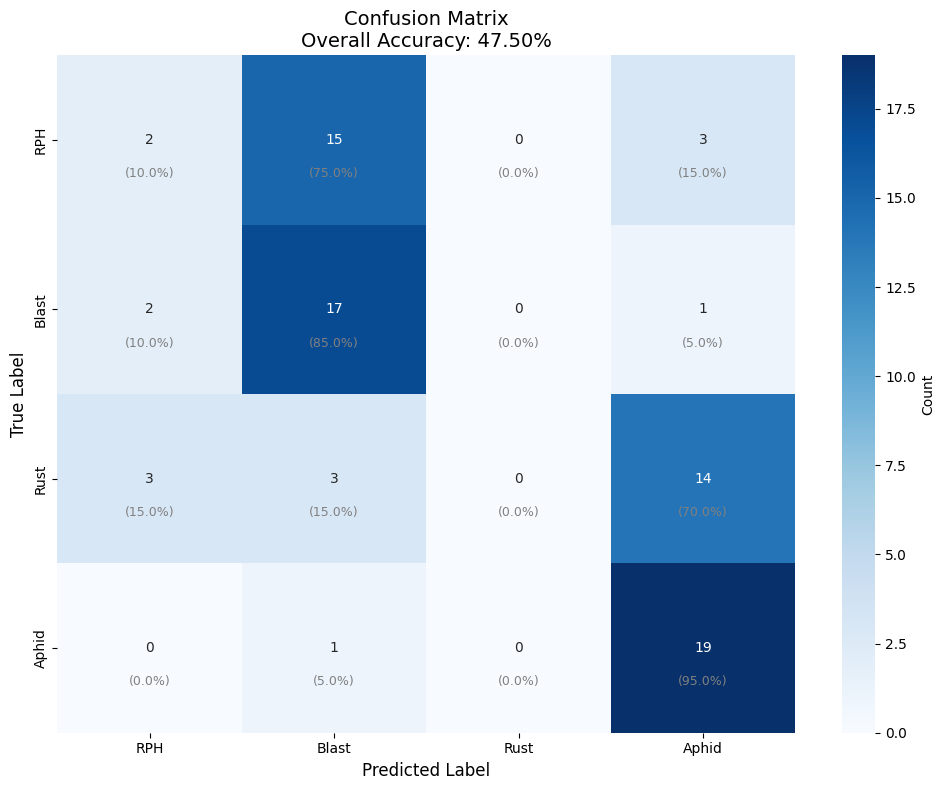


Overall Accuracy: 47.50%
Total Samples: 80



In [51]:
# After training completes, load best model and evaluate
print("\n" + "="*60)
print("FINAL EVALUATION ON BEST MODEL")
print("="*60)

best_model = ClassificationModel()
best_model.load_state_dict(torch.load("sanity_classification_checkpoints/best_classifier.pth")["model_state_dict"])

final_results = evaluate_model(
    model=best_model,
    dataloader=val_loader,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    class_names=['RPH', 'Blast', 'Rust', 'Aphid'],
    save_path='classification_checkpoints/final_confusion_matrix.png'
)
